## <b>분석 주제(2조): 90년대 말 ~ 2020년대 초 멜론차트 Top 50 곡 정보 분석을 통한 대중음악의 변화 양상 고찰<b>

### * 분석 목차
#### <b>1. 개요<b>
#### <b>2. 크롤링과 데이터 프레임 생성<b>  
###### - 2-1) 연도(1998,2003,2008,2013,2018,2023)별 Top 50 노래제목, 가수, 가사 크롤링
###### - 2-2) 데이터 프레임 생성/저장
#### <b>3. 분석 및 시각화<b>
###### - 3-1) 연도별 멜론차트 1위 곡 기록한 가수 분석
###### - 3-2) 연도별 Top 50 곡의 전체 가사를 바탕으로 한 시각화
#### <b>4. 결과 해석/결론<b>

### 0. 필요한 패키지 임포트

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd
import warnings
import re
from pytz import timezone
import datetime
import koreanize_matplotlib
warnings.filterwarnings('ignore')
options = webdriver.ChromeOptions()
# 원격 컨트롤을 방해하는 설정 막음
options.add_argument('--no-sandbox') # 보안 기능인 샌드박스 비활성화
options.add_argument('--disable-dev-shm-usage') # dev/shm 디렉토리 사용 안함
koreanize_matplotlib.koreanize() # 플롯에 한글 깨짐 방지

### <b>1. 개요<b>

대중 가요는 시대의 흐름과 발맞추어 모습을 탈바꿈한다. 서로 다른 시대에는 서로 다른 분위기와 멋을 풍기는 멜로디와 가사가 살아 숨쉬고 있다. 거시적인 관점에서 대중 가요 가사의 흐름을 살펴보는 것은 시대별 대중 가요에 대한 예술가의 감성과 사람들의 정서를 엿볼 수 있다는 점에서 대중 가요에 대한 시대별 이해에 도움이 된다고 할 수 있다.         

### <b>2. 크롤링과 데이터 프레임 생성<b>

#### 2-1) 연도(1998,2003,2008,2013,2018,2023)별 Top 50 노래제목, 가수, 가사 크롤링

In [ ]:
# "https://www.melon.com/chart/age/index.htm?chartType=YE&chartGenre=KPOP&chartDate="
# 데이터 수집 순서
## 1. 연도 선택 -> 해당 연도 페이지로 이동 -> 연간차트 1~30위까지의 노래 제목, 가수 정보 수집
## 2. 각 노래 가사 수집
## 3. csv로 저장
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import re
# hold: top 50까지 출력하고 싶으면 hold=50 지정
def melon_collector(url, start,hold=50):
    print(f"{start}년도 멜론 Top30 수집 시작------")

    # 드라이버 초기화
    driver = webdriver.Chrome()  # ChromeDriver 경로를 지정해야 할 수도 있습니다.

    try:
        driver.get(url)
        time.sleep(3)

        # 스크롤 내리기
        driver.execute_script('window.scrollTo(0, 800)')
        time.sleep(3)

        html_source = driver.page_source
        soup = BeautifulSoup(html_source, 'html.parser')

        # 제목 수집

        # driver.find_elements는 element를 찾고 뭔가 액션을 하고 싶을 때 찾음 .으로 연결시킨다.
        titles = driver.find_elements(By.CSS_SELECTOR, '.ellipsis.rank01')
        title_list = [title.text for title in titles][:hold]
        print(title_list)

        # 가수 수집
        singers = driver.find_elements(By.CSS_SELECTOR, '.ellipsis.rank02')
        singer_list = [singer.text for singer in singers][:hold]
        print(singer_list)

        # 가사 수집을 위한 songid 추출 준비
        song_info = soup.find_all('div', {'class': 'ellipsis rank01'})

        songid_list = []
        for sid in song_info[:hold]:
            try:
                # 정규식 사용하여 숫자 아닌 부분 제거
                info_ = re.sub(r'[^0-9]', '', sid.find('a')['href'].split(',')[1])
                print(info_)
                songid_list.append(info_)
            except:
                songid_list.append('')
                print('song not found....')

        # 가사 수집
        song_cnt = 0
        lyrics_list = []
        for song_id in songid_list:
            if song_id:
                print(f"{song_cnt + 1} : {title_list[song_cnt]} 노래 가사 수집 중...")

                try:
                    song_url = f"https://www.melon.com/song/detail.htm?songId={song_id}"
                    driver.get(song_url)
                    time.sleep(4)

                    # 가사 더보기 버튼 클릭
                    try:
                        more_button = driver.find_element(By.CSS_SELECTOR, '.button_more.arrow_d')
                        more_button.click()
                        time.sleep(3)
                    except:
                        pass  # '더보기' 버튼이 없는 경우

                    # 가사 텍스트 추출
                    lyrics = driver.find_element(By.CSS_SELECTOR, '.lyric')
                    lyrics_list.append(lyrics.text)
                except Exception as e:
                    print(f"가사 수집 실패: {e}")
                    lyrics_list.append('')
            else:
                lyrics_list.append('')
            song_cnt += 1
        print(lyrics_list)

    except Exception as e:
        print(f"오류 발생: {e}")


    driver.quit()
    return title_list,singer_list,lyrics_list





start_yr = [1998,2003,2008,2013,2018,2023]
df_whole = pd.DataFrame()
for start in start_yr:
    url = ('https://www.melon.com/chart/age/index.htm?chartType=YE&chartGenre=KPOP&chartDate=') # 수정 불가하도록 튜플을 씀
    new_url = url + str(start)
    list_top50 = melon_collector(new_url,start)

    titles,singers,lyrics = list_top50
    df_tsl = pd.DataFrame({'제목':titles,'가수': singers,'가사':lyrics,'연도':start})
    # 정규식으로 \n \r 등 필요 없는 요소 제거와 앞뒤 공백 strip
    df_tsl['가사'] = df_tsl['가사'].str.replace('\[a-z]|\n',' ',regex=True).str.strip()
    df_whole = pd.concat([df_whole,df_tsl],axis=0)
df_whole.reset_index(drop=True,inplace=True)

df_whole.head()

1998년도 멜론 Top30 수집 시작------
['Poison', '그녀와의 이별', '애상', '지킬 수 없는 약속', '애인이 생겼어요', 'Dreams Come True', '뻐꾸기 둥지위로 날아간 새', '나나나', '믿음', '착한 사랑', 'To Heaven (천국으로 보낸 편지)', '나와 같다면', '사랑을 위하여', '나의 사랑 천상(天上)에서도', 'P.S. I Love You', '비(悲)', 'Epilogue(에필로그)', '사람이 꽃보다 아름다워', '거꾸로 강을 거슬러 오르는 저 힘찬 연어들처럼', '진심', "('Cause) I'm Your Girl", '난 그래', '보낼수밖에 없는 난', '행복한 나를', '일상으로의 초대 (Radio Mix)', '헤어진 다음날', '내 낡은 서랍 속의 바다', 'Everybody', 'Love Love', '비원(悲願)', '세상이 그대를 속일지라도', '회상 (December)', '해에게서 소년에게', '외출', '사랑한 후에', '먼 훗날', '눈물 내리는 날 (비)', '내게 너무 이쁜 그녀', '혼자한 사랑', '배려', '알고 싶어요!', '하나의 사랑', '슬픈 얼굴', 'Love Song', '널 위해 준비된 사랑', '눈물', '그녀의 생일', 'Honey', '길', '거짓말도 보여요']
['엄정화', '김현정', '쿨 (COOL)', '신승훈', '터보', 'S.E.S.', '김건모', '유승준', '이소라', '김민종', '조성모', '김장훈', '김종환', '김경호', '박정현', '김정민', '김종서', '안치환', '강산에', '김광진', 'S.E.S.', '리아', '소찬휘', '에코', '신해철', '이현우', '패닉', '진주', '비쥬', '박상민', '김장훈', '터보', '넥스트', '최재훈', '신성우', 'YB (윤도현 밴드)', '조 트리오', '아낌없이 주는 나무', '김현정', '김동률', '양파', '박상민', 'A.R.T', '김종서', '

KeyboardInterrupt: 

#### 2-2) 데이터 프레임 생성/저장

In [ ]:
import os
os.chdir(r"C://Users/kimseongseop/Desktop")
# 연도가 합쳐진 데이터를 csv 파일 형식으로 저장
df_whole.to_csv("top_50_인기곡(1998_2023).csv",encoding='utf-8-sig')

In [ ]:
# 코드 참조하시는 분들은 해당 셀에 있는 코드는 실행하지 마시기 바랍니다:)
import os
os.chdir(r"C://Users/kimseongseop/Downloads/")
# 크롤링된 데이터 읽어들임
df_whole = pd.read_csv("top_50_인기곡(1998_2023).csv").iloc[:,1:]
df_whole

,노래제목,가수,가사,연도
0,Poison,엄정화,널 뒤로한채 그냥 걸었어미안해 하는 널 위해참아온 눈물 보이기 싫어 나 먼저 일어...,1998
1,그녀와의 이별,김현정,이제 우리 정말 끝난거야 니가 다시 확인시켜줬지 그럴 필요까진 없었는데 마지막 자...,1998
2,애상,쿨 (COOL),알잖아 너를 이토록 사랑하며 기다린 나를 뭐가 그리 바쁜지너무 보기 힘들어넌 도대...,1998
3,지킬 수 없는 약속,신승훈,용서해 주겠니 너와의 약속지킬수가 없어니 모든걸 사랑하겠다는지난날의 약속니가 사랑...,1998
4,애인이 생겼어요,터보,YeahMy Found My True LoveThis Is The Story왜 너...,1998
...,...,...,...,...
295,그라데이션,10CM,밤은 다시 길고 깊어졌네나는 점점 너로 잠 못 들게 돼글로 적어내긴 어려운 이 기...,2023
296,내가 아니라도,주호,사랑이었다 별거 없던 내 하루에빛이 돼준 단한 사람나보다 나를 더 아껴 주던 너를...,2023
297,후라이의 꿈,AKMU (악뮤),저 거위도 벽을 넘어 하늘을 날을 거라고달팽이도 넓고 거친 바다 끝에 꿈을 둔다고...,2023
298,Cupid,FIFTY FIFTY,불꺼진 romantic all my life내 주위는 온통 lovely day내 ...,2023


## <b>3. 분석 및 시각화<b>
### - 3-1) 연도별 멜론차트 1위 곡 기록한 가수 분석

In [ ]:
# 연도별 랭킹 1위 곡과 그 가수 분석
df_1deung = df_whole.groupby('연도',as_index=False).apply(lambda x: x.head(1)[['연도','노래제목','가수','가사']] ).reset_index(drop=True)
df_1deung

,연도,노래제목,가수,가사
0,1998,Poison,엄정화,널 뒤로한채 그냥 걸었어미안해 하는 널 위해참아온 눈물 보이기 싫어 나 먼저 일어...
1,2003,Break Away,빅마마,이젠 날 떠나가줘 이젠 날 다 잊어줘 나를 버리고 살아가줘 가져간 내 사랑을 내게...
2,2008,So Hot,원더걸스,왜 자꾸 쳐다보니 왜 내가 그렇게 예쁘니 아무리 그렇다고 그렇게 쳐다보면 내가 좀...
3,2013,자니 (Feat. Dynamic Duo),프라이머리,일 끝나서 친구들과 한잔내일은 노는 토요일이니깐일 얘기 사는 얘기 재미난 얘기시간...
4,2018,사랑을 했다 (LOVE SCENARIO),iKON,사랑을 했다 우리가 만나 지우지 못할 추억이 됐다 볼만한 멜로드라마 괜찮은 결말 그...
5,2023,Ditto,NewJeans,Woo woo woo woo oohWoo woo woo wooStay in the...


In [ ]:
# 연도별 1위 가수의 다른 top 50 차트 입성곡들
df_1deung_singer = df_1deung['가수']
df_whole[df_whole['가수'].isin(list(df_1deung_singer))].set_index(['가수','연도'])

노래제목  \
가수       연도                                           
엄정화      1998                                Poison   
빅마마      2003                            Break Away   
         2003                                    체념   
         2003                                    거부   
원더걸스     2008                                So Hot   
         2008                                Nobody   
프라이머리    2013                자니 (Feat. Dynamic Duo)   
         2013  ? (물음표) (Feat. 최자 Of 다이나믹듀오, Zion.T)   
         2013      씨스루 (Feat. Zion.T, 개코 Of 다이나믹듀오)   
iKON     2018                사랑을 했다 (LOVE SCENARIO)   
NewJeans 2023                                 Ditto   
         2023                              Hype Boy   
         2023                                   OMG   
         2023                             Attention   
         2023                             Super Shy   
         2023                                   ETA   

                                                              가사  
가수       연도                                                       
엄정화      1998   널 뒤로한채 그냥 걸었어미안해 하는 널 위해참아온 눈물 보이기 싫어 나 먼저 일어...  
빅마마      2003   이젠 날 떠나가줘 이젠 날 다 잊어줘 나를 버리고 살아가줘 가져간 내 사랑을 내게...  
         2003   행복했어너와의 시간들아마도너는 힘들었겠지너의 마음을몰랐던 건 아니야나도 느꼈었지만...  
         2003   자꾸 재촉하지마터질 것만 같아아직 끝이 아니야난 널 믿지 않아나 그런 눈으로바라보...  
원더걸스     2008   왜 자꾸 쳐다보니 왜 내가 그렇게 예쁘니 아무리 그렇다고 그렇게 쳐다보면 내가 좀...  
         2008   You Know I still Love You Baby And it will ne...  
프라이머리    2013   일 끝나서 친구들과 한잔내일은 노는 토요일이니깐일 얘기 사는 얘기 재미난 얘기시간...  
         2013   전화를 할까 말까 문자로 할까 아 시간이 너무 늦었나 그녀는 벌써 잘까 오늘따라 ...  
         2013   Party time 아는 사람 없네지루해 앉아있기만 해바텐더 뭘 마셔야 해 그래 ...  
iKON     2018  사랑을 했다 우리가 만나 지우지 못할 추억이 됐다 볼만한 멜로드라마 괜찮은 결말 그...  
NewJeans 2023   Woo woo woo woo oohWoo woo woo wooStay in the...  
         2023   (1,2,3,4)Baby, got me looking so crazy빠져버리는 d...  
         2023   이 노래는 it’s about you babyOnly youYou you youY...  
         2023   You and me내 맘이 보이지 한참을 쳐다봐가까이 다가가You seeYou s...  
         2023   I’m super shy, super shyBut wait a minute whi...  
         2023   낭비하지 마 네 시간은 은행서둘러서 정리해 걔는 real bad받아주면 안돼No ...

### - 3-2) 연도별 Top 50 곡의 전체 가사를 바탕으로 한 워드클라우드 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import *
from wordcloud import WordCloud
os.chdir(r"C://Users/kimseongseop/Downloads/")

font_path = 'BMDOHYEON_ttf.ttf' #font로 배달의민족 도현체 사용
# 한국어와 영어로 구분하여 단어 전처리 해주고 워드클라우드 그려 주는 함수
def preprocess_words_and_draw_wc(df_tsl,year_designated,wc_colourmap,len_word=1,stopwords=["",'ll','is','no','so','ok','you','wo','yes','are','m','ah','in','ah ah','da da','hip hip','hip','da','내','날','내가','모든','은','는','이','가','이가','으로','아','게','에','그','어','a','the','aa','it','this','an','i','what']):
    # 모든 단어 추출하여 불용어 제거
    all_lyrics = ' '.join(df_tsl['가사'])
    words = re.findall(r'[\b\w+\b]+',all_lyrics.lower()) # 탈출 문자 무시하는 r string으로
    words = [word for word in words if word not in stopwords]
    # 영어 단어만 추출하여 불용어 제거
    words_eng = re.findall(r'[a-zA-Z]+',all_lyrics.lower())
    words_eng = [word for word in words_eng if word not in stopwords]
    # 한국어 처리기로 판단된 한국어 명사만 추출
    komoran = Komoran()
    words_kor_noun = komoran.nouns(" ".join(list(words)))
    ### (블록)불용어 사전 외부에서 가져와 한국어 불용ㅁ어 더 필터 ###
    stop_words = pd.read_csv("C://Users/kimseongseop/Desktop/stop_words_korean.csv")
    stop_words_list =list(stop_words['stop_words'])
    words_kor_noun = [word for word in words_kor_noun if (word not in stop_words_list) and (len(word)>=len_word)]
    ### (블록)위 블록은 디테일한 요소이므로 불용어 파일을 찾을 수 없다면 무시해도 무방함 ###
    noun_str = " ".join(words_kor_noun + words_eng)
    # 워드클라우드 시각화 파트
    wc = WordCloud(max_words=50,width = 4500, height = 2500, background_color="black",colormap=wc_colourmap,font_path=font_path).generate(noun_str)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(year_designated+"년 시각화",fontdict={'size':20,'color':'crimson'})






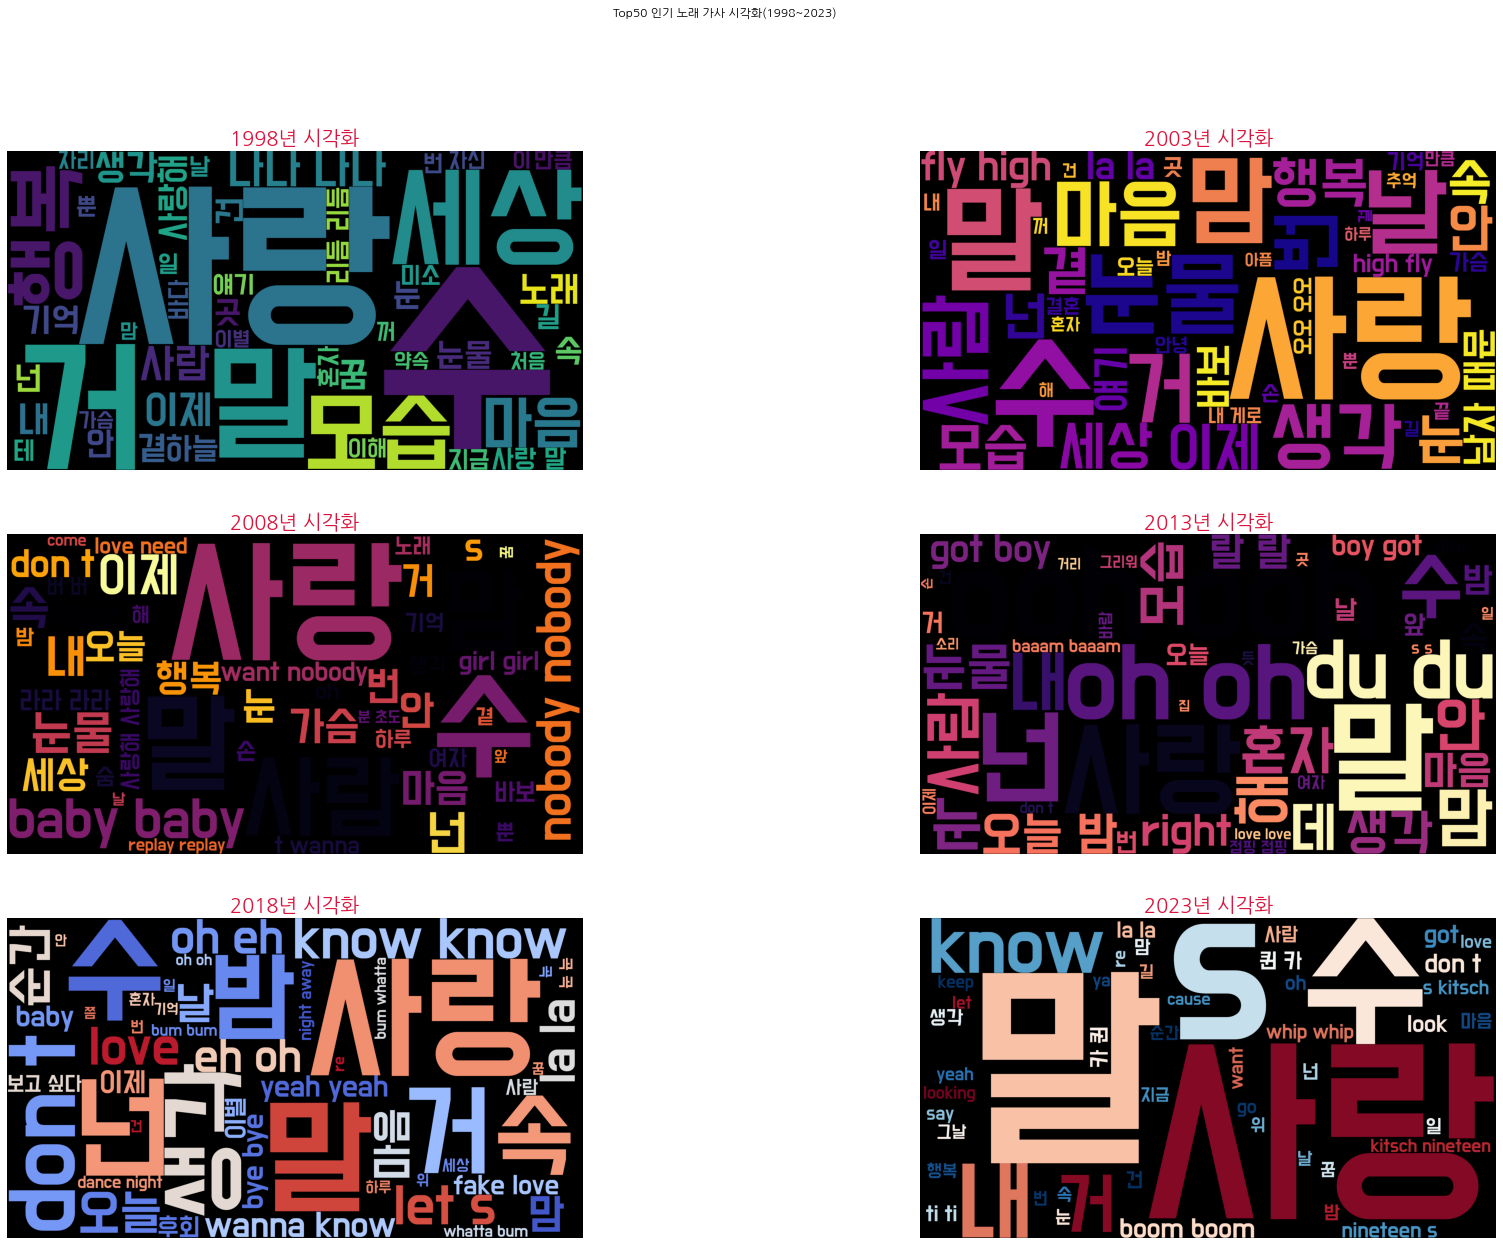

In [ ]:
# 최종 시각화 결과 subplot에 출력
plt.figure(figsize=(30,20))
# 출력 연도 리스트
start_yr = [1998,2003,2008,2013,2018,2023]
# 워드클라우드 컬러맵 리스트(글자 색상의 다변화를 위해)
colourmap_list = ["viridis", "plasma", "inferno", "magma","coolwarm", "RdBu"]
for i,(yr,clur) in enumerate(zip(start_yr,colourmap_list),1):
    plt.subplot(int(f"32{i}"))
    preprocess_words_and_draw_wc(df_tsl=df_whole[df_whole['연도']==yr],wc_colourmap=clur,year_designated=str(yr))
plt.suptitle('Top50 인기 노래 가사 시각화(1998~2023)\n')
plt.show()

#### <b>4. 결과 해석/결론<b>

##### 1. 시대(1998~2023)를 불문하고 '사랑' 이라는 주제는 인기 가요들의 주요 관심사임을 확인 가능
##### 2. 영어 가사와 영어 후크송의 등장이 이 시기(1998~2023) 안에 점진적으로 이루어졌음을 추론 가능
##### 3. '사랑','말','마음' 이란 단어는 시대를 불문하고 많이 쓰였지만, '세상' 이란 단어는 쓰이는 비중이 감소했음을 확인할 수 있다. 대신 다양한 영어 단어들이 시대가 흐를수록 더 많이 쓰였다.